In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# GETTING DATA 

In [2]:
def get_image_generator (preprocessing_function=None, validation_split=0.0, horizontal_flip=False):
    
    image_generator = ImageDataGenerator(preprocessing_function=preprocessing_function,
                                         validation_split=validation_split,
                                         horizontal_flip=True)
    
    return image_generator

In [3]:
train_validation_image_generator = get_image_generator(preprocessing_function=preprocess_input,
                                                       validation_split=0.1,
                                                       horizontal_flip=True)


test_image_generator = get_image_generator(preprocessing_function=preprocess_input,
                                           validation_split=0.0,
                                           horizontal_flip=False)
                                              

In [4]:
def get_train_val_data_sets(directory, image_generator, target_size, batch_size=32): 

    train_set = image_generator.flow_from_directory(directory=directory, 
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                subset='training')

    validation_set = image_generator.flow_from_directory(directory=directory, 
                                                     target_size=target_size,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     subset='validation')
    return train_set, validation_set 


In [5]:
def get_test_data_set(directory, image_generator, target_size, batch_size=32): 

    test_set = image_generator.flow_from_directory(directory=directory, 
                                                   target_size=target_size,
                                                   batch_size=batch_size,
                                                   shuffle=True,)

    return test_set 


In [6]:
target_size = (224,224)
batch_size = 128

directory =  os.getcwd() + "\\train"

train_set, validation_set = get_train_val_data_sets(directory,
                                                    train_validation_image_generator, 
                                                    target_size=target_size,
                                                    batch_size=batch_size)

directory =  os.getcwd() + "\\test"

test_set = get_test_data_set(directory, 
                             test_image_generator, 
                             target_size=target_size,
                             batch_size=batch_size)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 512 images belonging to 2 classes.


# DATA VISUALIZATION 

In [7]:
def show_images(data_batch, labels, nrow, ncol):    

    batch_images = np.array(data_batch[0])
    batch_labels = np.array(data_batch[1] )
    

    plt.figure(figsize = (20,10))

    for i in range(nrow*ncol):
        ax = plt.subplot(nrow, ncol, i+1)
        plt.imshow(batch_images[i])
        plt.title(labels[np.where(batch_labels[i]==1)[0][0]])
        plt.axis('off')
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

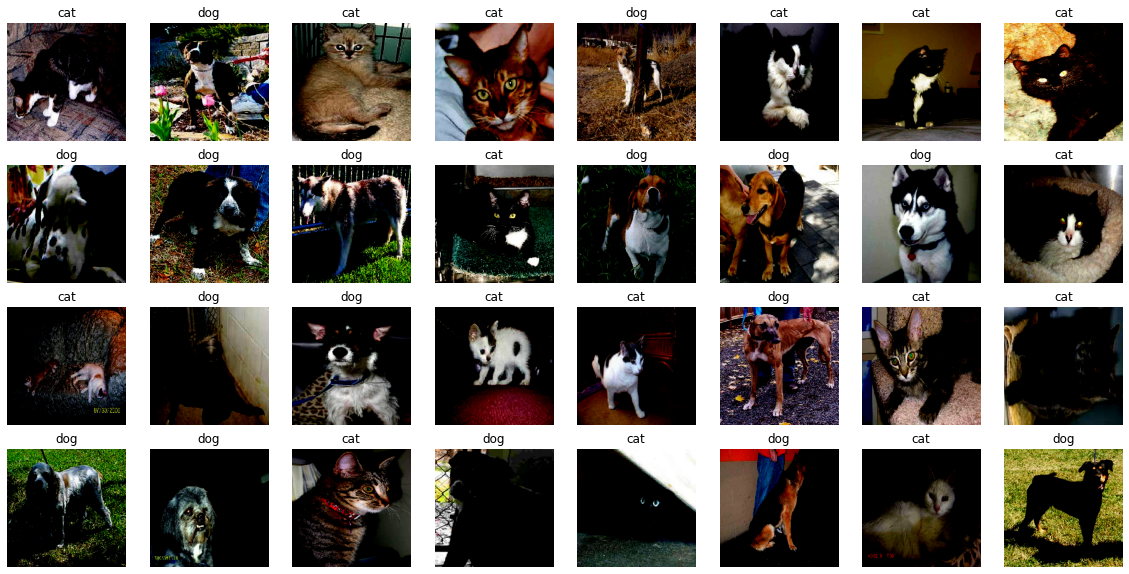

In [8]:
data_batch = next(train_set)
labels = ['cat', 'dog']
nrow = 4
ncol=8

show_images(data_batch, labels, nrow, ncol)

# MODEL COMPILING 

In [9]:
def get_model (input_shape):
  
    mobilenet_model = MobileNet(input_shape=input_shape, include_top=False)

    model = Sequential([mobilenet_model,
                        Flatten(),
                        Dense(64, activation="relu"), 
                        Dense(64, activation="relu"), 
                        Dense(64, activation="relu"), 
                        Dense(2, activation="softmax")                         
                        ])
  
    model.layers[0].trainable = False 

    return model

In [10]:
input_shape = (target_size[0], target_size[1], 3)
model = get_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3211328   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 6,448,642
Trainable params: 3,219,778
Non-trainable params: 3,228,864
______________________________________

In [11]:
def compile_model(model, optimizer, loss):
    
    model.compile(optimizer=optimizer, loss=loss, metrics =["accuracy"])
    
    return model 

In [12]:
model = compile_model(model, SGD(learning_rate=0.0001),BinaryCrossentropy())

# MODEL TRAINING  

In [13]:
#reset generator
directory =  os.getcwd() + "\\train"
target_size = (224,224)
batch_size = 128
train_set, validation_set = get_train_val_data_sets(directory,
                                                    train_validation_image_generator,
                                                    target_size=target_size,
                                                    batch_size=batch_size)


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [14]:
def train_model (train_set, steps_per_epoch, validation_set, validation_steps, epochs, callbacks):
    
    history = model.fit(train_set, 
                        steps_per_epoch=steps_per_epoch, 
                        validation_data=validation_set,
                        validation_steps=validation_steps, 
                        epochs=epochs,
                        callbacks=[early_stopping])
    return history 

In [15]:
steps_per_epoch = train_set.samples//batch_size
validation_steps = validation_set.samples//batch_size
epochs = 15
early_stopping = EarlyStopping(patience=2, monitor='val_accuracy', mode="max")
callbacks=[early_stopping]

history = train_model (train_set, steps_per_epoch, validation_set, validation_steps, epochs, callbacks)

Epoch 1/15
175/175 [==============================] - 512s 3s/step - loss: 0.6844 - accuracy: 0.6360 - val_loss: 0.4218 - val_accuracy: 0.8972
Epoch 2/15
175/175 [==============================] - 519s 3s/step - loss: 0.3565 - accuracy: 0.9227 - val_loss: 0.2262 - val_accuracy: 0.9482
Epoch 3/15
175/175 [==============================] - 539s 3s/step - loss: 0.2027 - accuracy: 0.9570 - val_loss: 0.1538 - val_accuracy: 0.9667
Epoch 4/15
175/175 [==============================] - 540s 3s/step - loss: 0.1463 - accuracy: 0.9634 - val_loss: 0.1273 - val_accuracy: 0.9688
Epoch 5/15
175/175 [==============================] - 952s 5s/step - loss: 0.1194 - accuracy: 0.9673 - val_loss: 0.1091 - val_accuracy: 0.9692
Epoch 6/15
175/175 [==============================] - 595s 3s/step - loss: 0.0981 - accuracy: 0.9734 - val_loss: 0.0991 - val_accuracy: 0.9720
Epoch 7/15
175/175 [==============================] - 596s 3s/step - loss: 0.0927 - accuracy: 0.9748 - val_loss: 0.0889 - val_accuracy: 0.9753

# MODEL EVALUATION

In [16]:
loss = pd.DataFrame(history.history)

In [17]:
loss.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

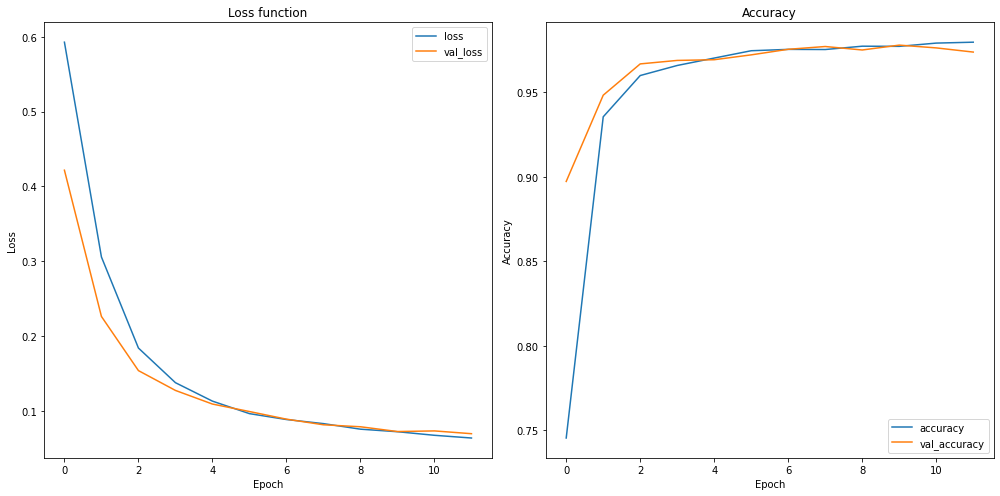

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))

ax[0].plot(loss["loss"], label="loss")
ax[0].plot(loss["val_loss"], label = "val_loss")
ax[0].legend(loc='upper right')
ax[0].set_title("Loss function")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")


ax[1].plot(loss["accuracy"], label="accuracy")
ax[1].plot(loss["val_accuracy"], label = "val_accuracy")
ax[1].legend(loc='lower right')
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")

fig.tight_layout()

In [19]:
model.evaluate(test_set)

4/4 [==============================] - 13s 3s/step - loss: 0.0427 - accuracy: 0.9844


[0.04272523894906044, 0.984375]

In [20]:
batch =  next(test_set)
test_images = batch[0]
test_labels =  batch[1]

for _ in range (test_set.samples//batch_size - 1):
    batch =  next(test_set)
    test_images = np.append(batch[0], test_images, axis=0)
    test_labels = np.append(batch[1], test_labels, axis=0 )


In [21]:
predictions = model.predict(test_images)

In [22]:
idx = np.argmax(predictions, axis=-1)
predictions = np.zeros( predictions.shape )
predictions[np.arange(predictions.shape[0]), idx] = 1

In [23]:
print(classification_report(np.argmax(test_labels, axis=-1),np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       245
           1       0.99      0.99      0.99       267

    accuracy                           0.99       512
   macro avg       0.99      0.99      0.99       512
weighted avg       0.99      0.99      0.99       512



In [24]:
print(confusion_matrix(np.argmax(test_labels, axis=-1),np.argmax(predictions, axis=-1)))

[[242   3]
 [  4 263]]


# MODLE SAVING

In [25]:
model.save("cat_dog_recognition_model.h5")